# Training of an autoencoder using a subset of the images

In [8]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import skimage.filters
from skimage.filters import gaussian
from scipy import ndimage as ndi
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import scipy.ndimage
import numba
import random

from copy import copy, deepcopy


import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

In [9]:
noise_filter = True
apply_absmax = True
absmax_size = 3
gauss_sigma = 2

## Reading and normalizing the images

In [10]:
# Read images
file_list = glob.glob("data/hmi_magnetogram/2016*.fits")
print(len(file_list))

HMI_m_2016 = sunpy.map.Map(file_list)

HMI_m_2016_matrix = np.array(list(d.data for d in HMI_m_2016))

HMI_m_2016_mnorm = dg.HMImGenerator.normalize(HMI_m_2016_matrix)

input_train, input_test = train_test_split(HMI_m_2016_mnorm, test_size=0.25)

2908


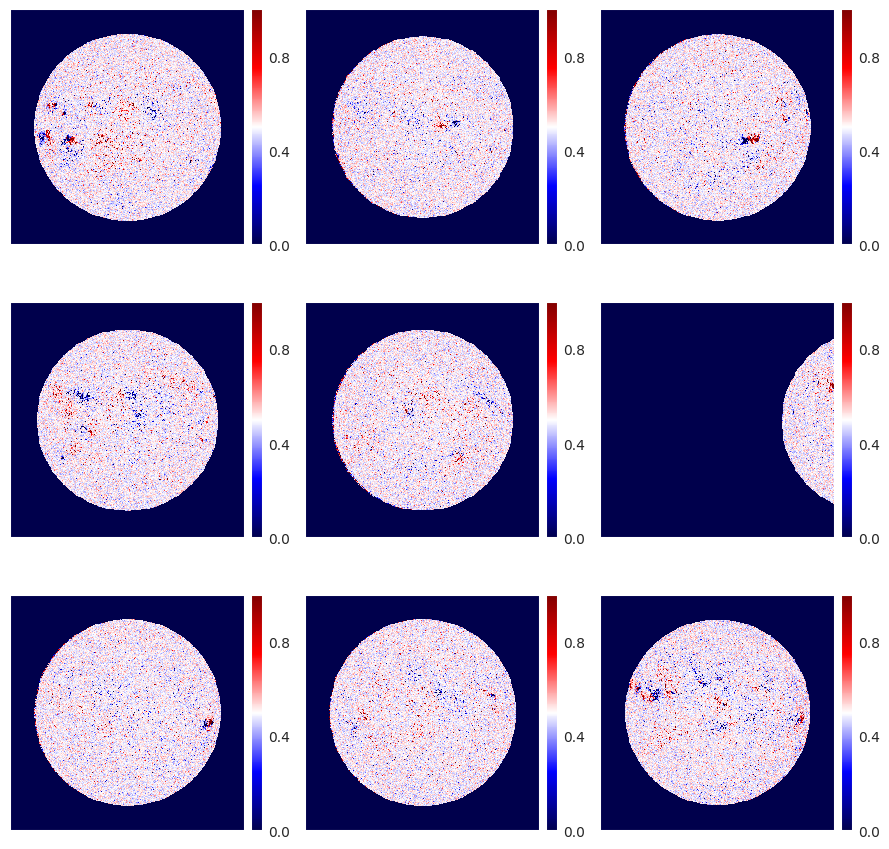

In [11]:
# aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in HMI_m_2016_mnorm[:9]], cmap="seismic", vmin=0, vmax=1)

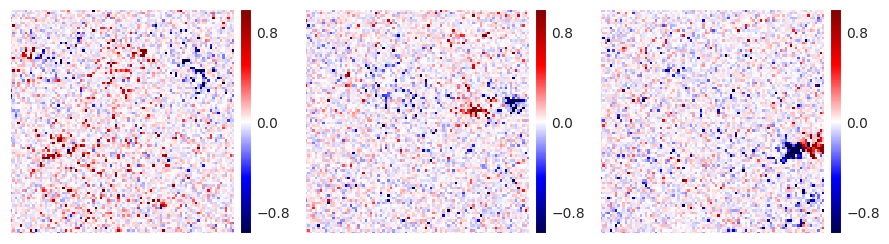

In [12]:
first_3_copy = 2*np.copy(HMI_m_2016_mnorm[:3, 80:170, 80:170])-1

isns.ImageGrid(
    [i for i in first_3_copy],
    cmap="seismic",
    col_wrap=3,
    vmin=-1,
    vmax=1
)


(0.0, 1.0) (-1.0, 1.0) (0.0, 1.0)


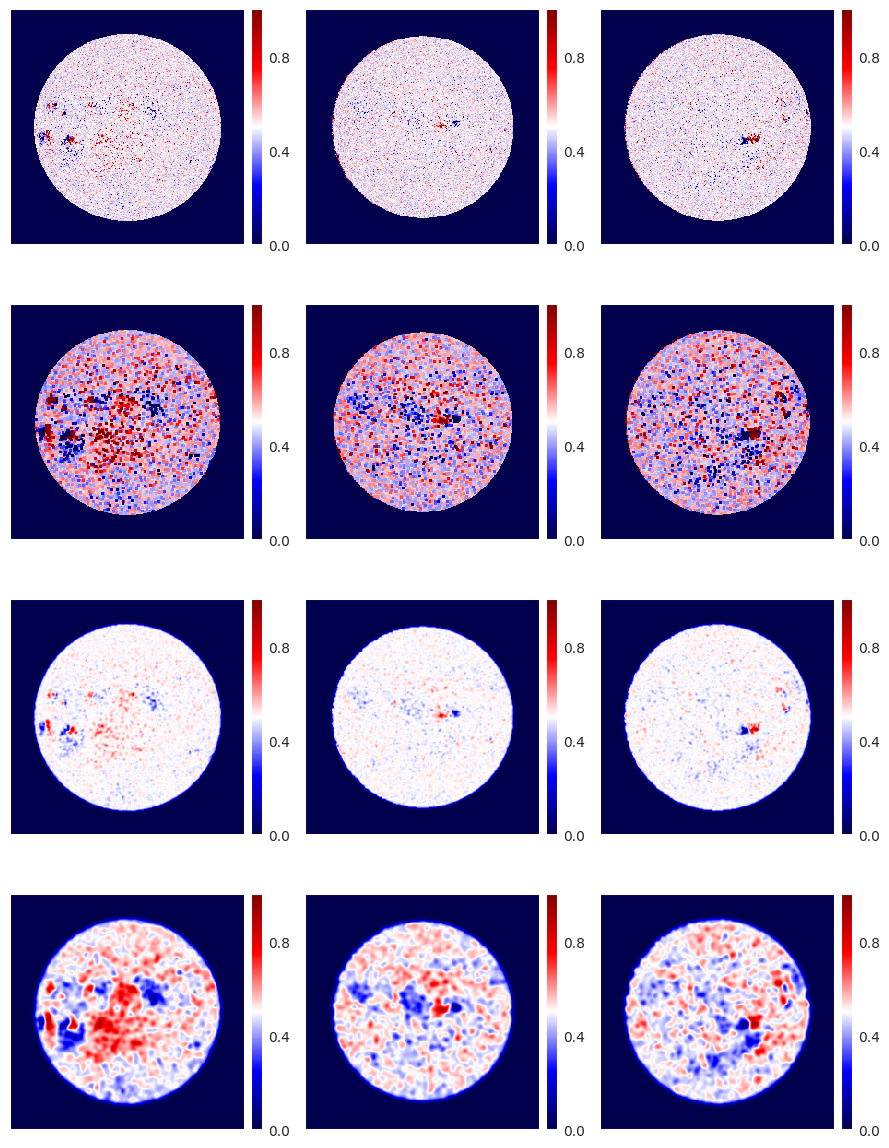

In [15]:
# base_filter = lambda x: gaussian(abs_max_filter(x, absmax_size), sigma=gauss_sigma)
repair_filter = lambda x: gaussian(utils.abs_max_filter(2*x - 1, absmax_size)/2 + 0.5, gauss_sigma)

first_3_copy = np.copy(HMI_m_2016_mnorm[:3])

print(utils.range_tuple(first_3_copy), utils.range_tuple(2*first_3_copy - 1), utils.range_tuple(((2*first_3_copy - 1) + 1)/2))

isns.ImageGrid(
    [i for i in first_3_copy],
    cmap="seismic",
    map_func=[lambda x: x, lambda x, **params: utils.abs_max_filter(2*x - 1, **params)/2 + 0.5, gaussian, repair_filter],
    map_func_kw=[{}, {"kernel_size": absmax_size}, {}, {}],
    col_wrap=3,
    vmin=0,
    vmax=1
)

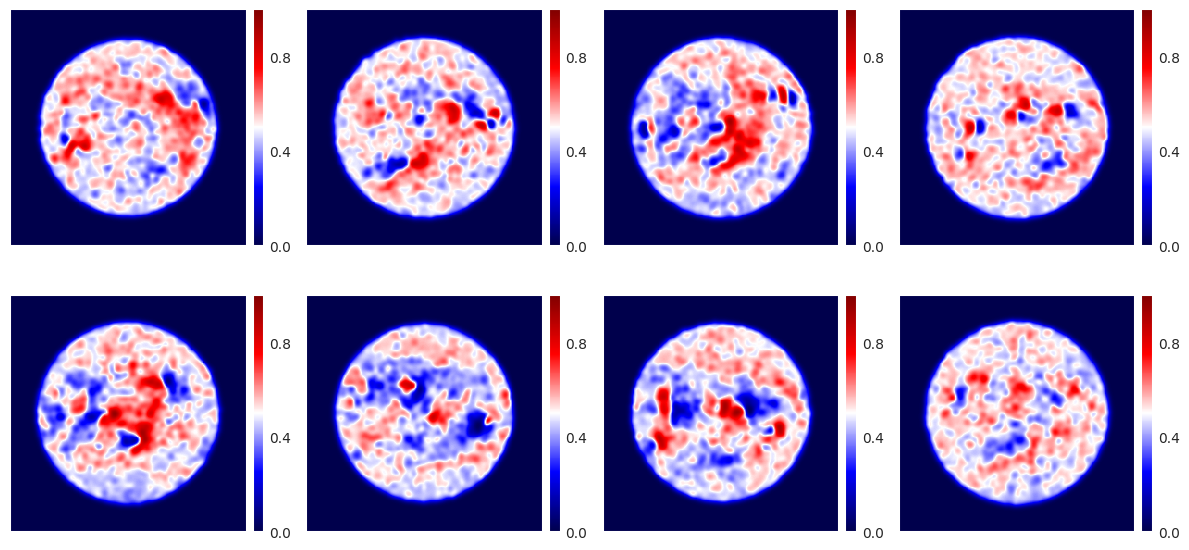

In [16]:
if apply_absmax:
    input_train = gaussian(utils.abs_max_filter_par(2*input_train - 1, absmax_size)/2 + 0.5, sigma=gauss_sigma, channel_axis=0)
    input_test = gaussian(utils.abs_max_filter_par(2*input_test - 1, absmax_size)/2 + 0.5, sigma=gauss_sigma, channel_axis=0)

    # input_train = skimage.restoration.denoise_tv_chambolle(input_train, channel_axis=0)
    # input_test = skimage.restoration.denoise_tv_chambolle(input_test, channel_axis=0)


isns.ImageGrid(random.sample(list(input_train), 4) + random.sample(list(input_test), 4), col_wrap=4, cmap="seismic",vmin=0, vmax=1)

## Training the model

In [17]:
latent_size = 128
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)

autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         


2023-04-23 14:12:22.743332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-23 14:12:22.871755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-23 14:12:22.871858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
          

In [18]:
n_epochs = 125
batch_size = 128

# no_improve_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=1e-5)

# history = autoencoder.fit(input_train, input_train, epochs=n_epochs, validation_split=0.1, batch_size=batch_size, callbacks=[no_improve_callback])
history = autoencoder.fit(input_train, input_train, epochs=n_epochs, validation_split=0.1, batch_size=batch_size)

Epoch 1/125


2023-04-23 14:12:31.934341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-23 14:12:33.273860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-23 14:12:33.993966: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 [==============================] - 14s 302ms/step - loss: 0.1154 - mae: 0.2281 - val_loss: 0.1149 - val_mae: 0.2291
Epoch 2/125
16/16 [==============================] - 1s 73ms/step - loss: 0.1131 - mae: 0.2276 - val_loss: 0.1109 - val_mae: 0.2278
Epoch 3/125
16/16 [==============================] - 1s 73ms/step - loss: 0.1029 - mae: 0.2226 - val_loss: 0.0851 - val_mae: 0.2108
Epoch 4/125
16/16 [==============================] - 1s 73ms/step - loss: 0.0745 - mae: 0.2009 - val_loss: 0.0667 - val_mae: 0.1875
Epoch 5/125
16/16 [==============================] - 1s 73ms/step - loss: 0.0616 - mae: 0.1798 - val_loss: 0.0553 - val_mae: 0.1687
Epoch 6/125
16/16 [==============================] - 1s 73ms/step - loss: 0.0517 - mae: 0.1618 - val_loss: 0.0466 - val_mae: 0.1527
Epoch 7/125
16/16 [==============================] - 1s 72ms/step - loss: 0.0444 - mae: 0.1486 - val_loss: 0.0412 - val_mae: 0.1422
Epoch 8/125
16/16 [==============================] - 1s 72ms/step - loss: 0.0397 - mae

## Evaluating the model

23/23 [==============================] - 1s 19ms/step - loss: 0.0034 - mae: 0.0301


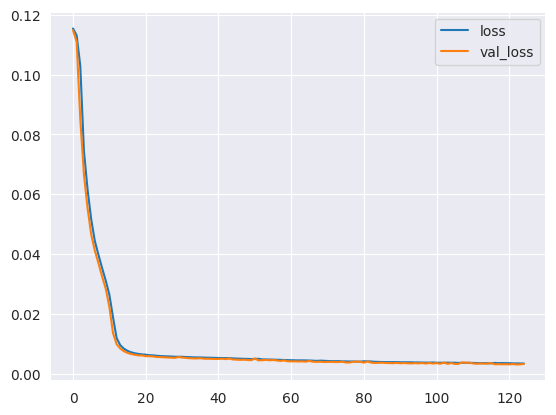

In [19]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 13ms/step


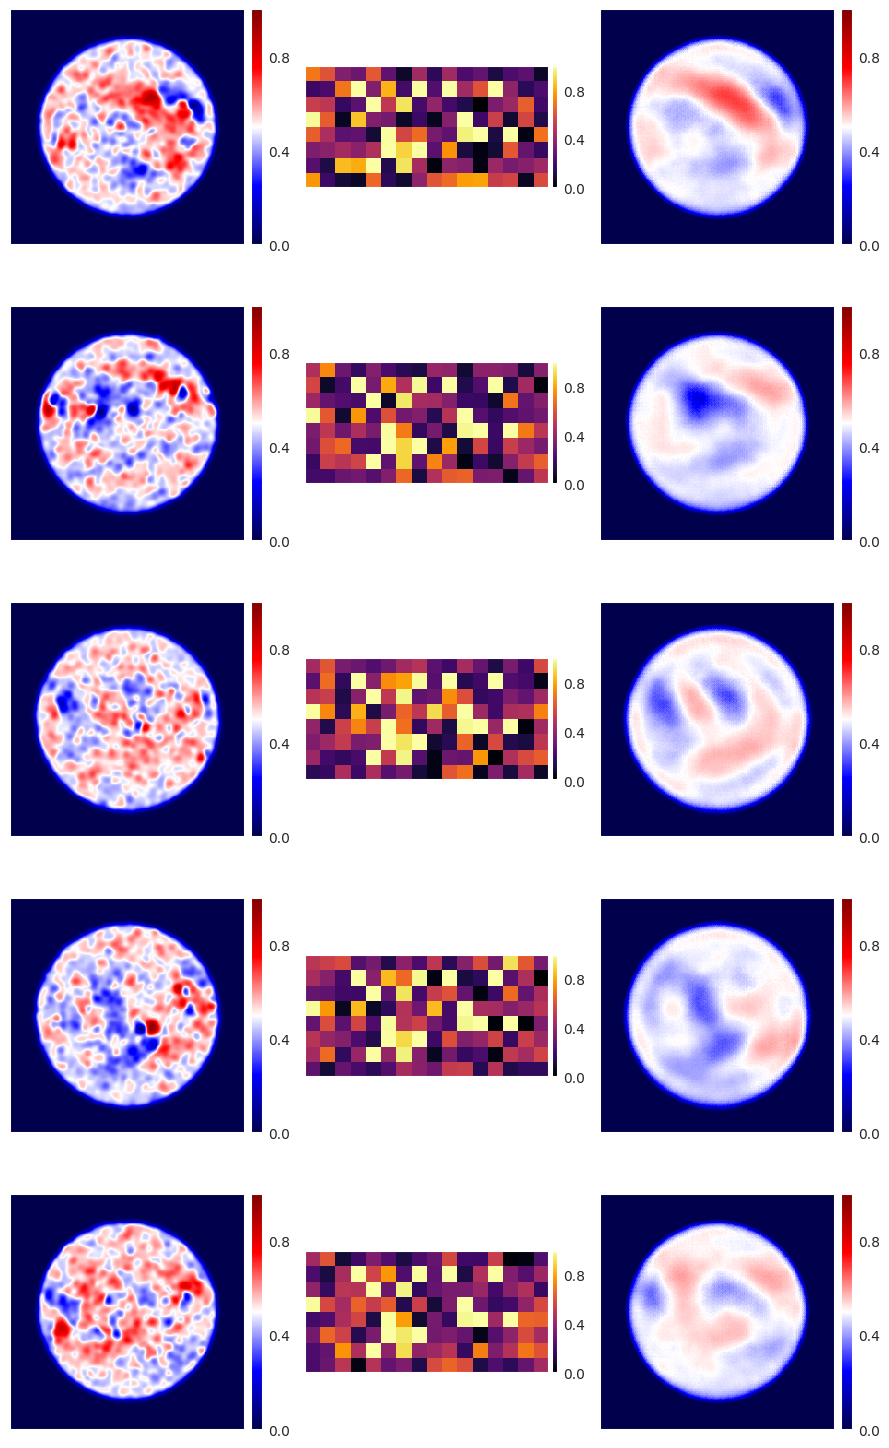

In [24]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=["seismic", "inferno", "seismic"]*5, vmin=0, vmax=1, col_wrap=3)

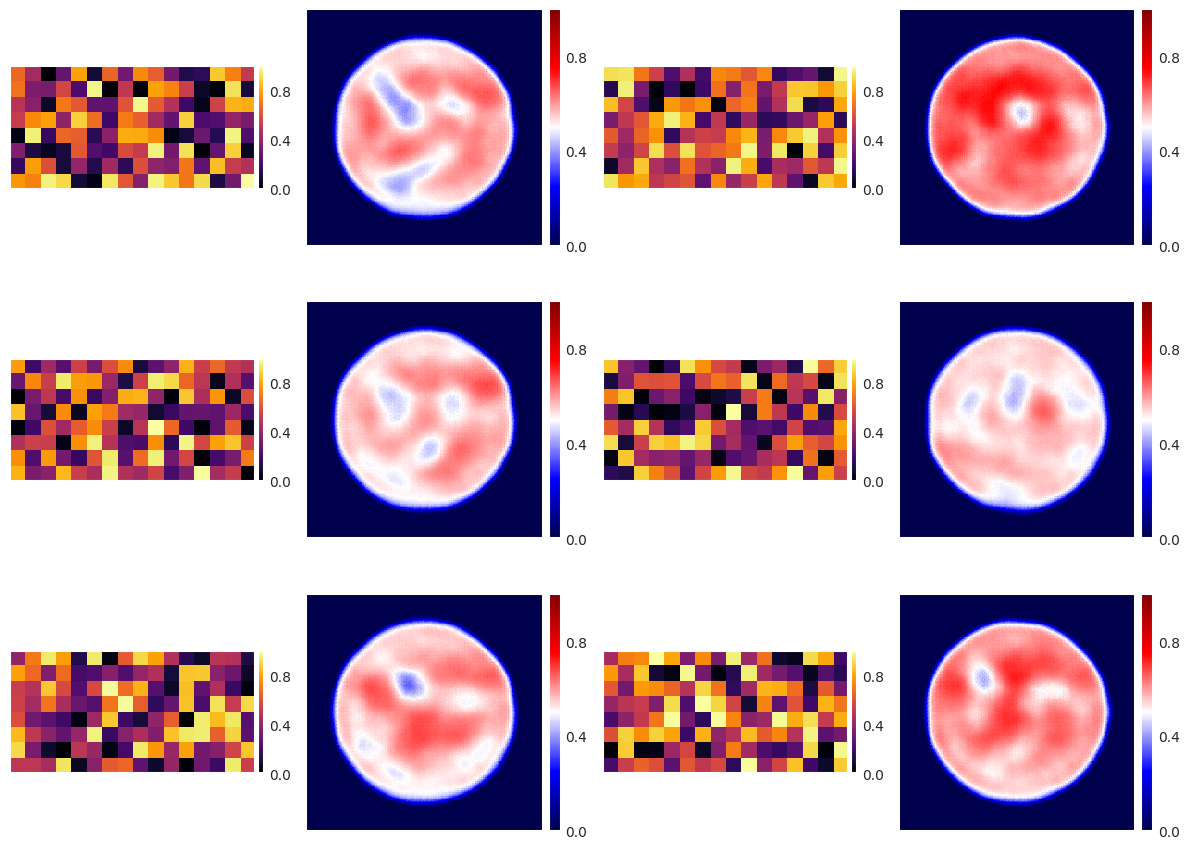

In [22]:
code = np.random.uniform(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(utils.square_dims_vector(i[0]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=["inferno", "seismic"]*6, vmin=0, vmax=1, col_wrap=4)